In [61]:
import torch
import torch.nn  as nn
import torch.nn.functional as F
import seaborn as sns

In [62]:
txt = """ #Title: The Chronicles of Terra

Chapter 1: The Awakening In the year 3025, the planet Terra had become a thriving hub of advanced technology and interstellar travel. Amidst this bustling world, a young engineer named Aria discovered an ancient artifact that would change her life forever.

Chapter 2: The Mysterious Artifact The artifact, a small, glowing sphere, seemed to pulse with energy. Aria couldn't decipher its origin, but she knew it held immense power. She decided to seek out the help of Dr. Lumin, an expert in ancient civilizations.

Chapter 3: Dr. Lumin's Laboratory Dr. Lumin was fascinated by the artifact and revealed that it was a relic from a long-lost civilization. "This sphere is a key to unlocking hidden knowledge," he explained. Together, they embarked on a quest to uncover its secrets.

Chapter 4: Journey to the Desert Their journey led them to the vast deserts of Terra, where the ancient civilization once thrived. As they navigated the treacherous terrain, they encountered mysterious symbols and hidden passages.

Chapter 5: The Guardian's Test At the heart of the desert, they discovered a hidden temple guarded by a formidable sentinel. "To proceed, you must prove your worth," the guardian declared. Aria and Dr. Lumin faced a series of challenges, testing their intellect and bravery. """

In [63]:
total_tokens = len(txt) # no of  training tokens

In [64]:
vocab = "".join(sorted(list(set(txt))))

In [65]:
# creating token id 

vocab = "".join(sorted(list(set(txt))))
vocab_size = len(vocab)
stoi = {v:i for i,v in enumerate(vocab)}

itos = {i:v for i,v in enumerate(vocab)}


In [66]:
encoder = lambda text: [stoi[s] for s in text]
decoder = lambda tokens: "".join([itos[i] for i in tokens])

decoder(encoder('hi fwwwwejw bcvwcb vtheredfwr'))



'hi fwwwwejw bcvwcb vtheredfwr'

In [67]:
encoder("#")


[3]

In [68]:
decoder([23,32,12,32])

'Sh4h'

In [69]:
block = 6
embed_dim = 32



In [70]:
encoded_txt = encoder(txt)

def get_batch(): 
    sample = torch.randint(0,total_tokens - block, (1,))
    x = [encoded_txt[sample+i]  for i in range(block)]
    y = [encoded_txt[sample+i+1]  for i in range(block)]
    batch_x = []

    #print('Word ==>',decoder(x))
    
    for batch in range(1,block+1):
        row = [3]*(block-batch) + x[:batch]
        batch_x.append(row )

        #print(decoder(row),"==>", decoder([y[batch-1]]))
    
    return torch.tensor(batch_x),torch.tensor(y)


get_batch()
    

(tensor([[ 3,  3,  3,  3,  3,  1],
         [ 3,  3,  3,  3,  1, 44],
         [ 3,  3,  3,  1, 44, 32],
         [ 3,  3,  1, 44, 32, 29],
         [ 3,  1, 44, 32, 29, 49],
         [ 1, 44, 32, 29, 49,  1]]),
 tensor([44, 32, 29, 49,  1, 38]))

In [71]:

sample = torch.randint(0,total_tokens - block, (1,))
sample

x = torch.tensor([encoded_txt[sample+i]  for i in range(block)])
y = torch.tensor([encoded_txt[sample+i+1]  for i in range(block)])


In [72]:
def pos_emb(seq,model_dim ):
    pos_vec = torch.zeros(size=(seq,model_dim))
    for pos in range(seq):
        for i in range(0,model_dim,2):
            val = torch.tensor(pos/((10000)**(2*i/model_dim)))
            pos_vec[pos,i] = torch.sin(val)
            pos_vec[pos,i+1] = torch.cos(val)
    return pos_vec

In [73]:
import matplotlib.pyplot as plt


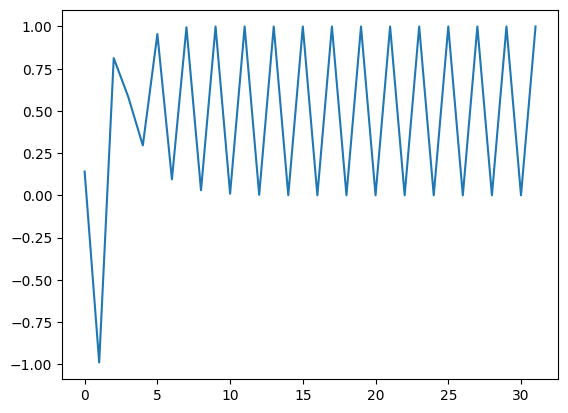

In [74]:
pos_digram = pos_emb(block,embed_dim)[3]
plt.plot(pos_digram)
plt.show()

In [75]:

tok_emb = nn.Embedding(vocab_size,embed_dim)
input_embed = tok_emb(x)
position_embedd = pos_emb(block,embed_dim)

position_aware_embed = input_embed + position_embedd
position_aware_embed.shape

torch.Size([6, 32])

In [76]:
class Head(nn.Module):
    def __init__(self,embed_dim): # (6,6,32)
        super().__init__()
        self.query = nn.Linear(embed_dim, embed_dim, bias=False) # 32,32,
        self.key = nn.Linear(embed_dim, embed_dim, bias=False) # 32,32
        self.value = nn.Linear(embed_dim, embed_dim, bias=False) # 32, 32

         # (6,6, 32)
    def forward(self, position_aware_embed):
        key_mat = self.key(position_aware_embed) # 6,6,32
        query_mat = self.query(position_aware_embed) #(6,6,32)
        value_mat = self.value(position_aware_embed) # (6,6,32)

        # Attantion layer
        attention = (query_mat @ key_mat.transpose(-1,-2))/(embed_dim**0.5) # (6,6,6)
        wei = attention.masked_fill(torch.tril(attention) == 0 , -torch.inf) # (6,6,6)
        wei = F.softmax(wei , dim=-1) 

        return wei @ value_mat #(6,6,32)
        #context_aware_emb 
head = Head(embed_dim)

In [77]:
class feedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(embed_dim , 128) # 32,128
        self.logit = nn.Linear(128,vocab_size) # 128,32

    def forward(self, x): # x=(6,6,32)
        x =  F.relu(self.l1(x)) # 6,6,128
        x = self.logit(x) # 6,6,128
        return F.softmax(x,dim=-1) # 6,6,32
    
projection = feedForward()
logit = projection(head(position_aware_embed))
id = torch.argmax(logit,dim=1)
id.tolist(),logit.shape

([50, 1, 1, 40, 50, 1], torch.Size([6, 51]))

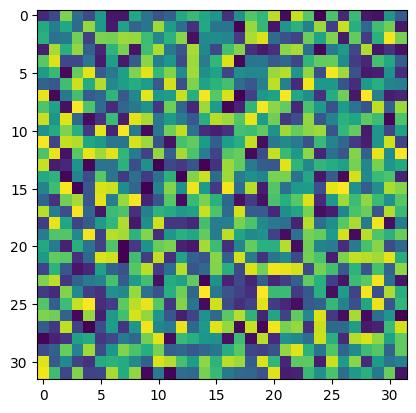

In [78]:
import numpy as np 
plt.imshow(np.array(list(head.parameters())[0].detach()))

In [81]:
        
head = Head(embed_dim)
projection = feedForward()

optim_dense = torch.optim.Adam((list(head.parameters()) + list(projection.parameters()) + list(tok_emb.parameters())), lr=0.1)

def train(epochs=100,lr =0.1):
    
    for i in range(epochs):
        sample = torch.randint(0,total_tokens - block, (1,))

        x,targets = get_batch() # torch.Size([6, 6]) torch.Size([6])

        input_embed = tok_emb(x)  #torch.Size([6, 6, 32])
        position_embedd = pos_emb(block,embed_dim).unsqueeze(1).expand(-1,6,-1)  #torch.Size([6, 6, 32])

        position_aware_embed = input_embed + position_embedd  #torch.Size([6, 6, 32])

        #forward pass
        head_out = head(position_aware_embed) # 6,6,32

        logits = projection(head_out) # 6,6,51
        

        logits_flattened = logits.view(-1, logits.size(-1))  # Shape: [36, 51]

        # Flatten targets to match the logits
        targets_flattened = targets.repeat(6)  # Shape: [36]

        # Compute cross-entropy loss
        loss = F.cross_entropy(logits_flattened, targets_flattened)

        # backward and optimize
        optim_dense.zero_grad()
        loss.backward()
        optim_dense.step()

        if i %1000 == 0:
            print(i,"loss :==>",loss)
train(epochs=10000,lr = 0.1)      

0 loss :==> tensor(3.9319, grad_fn=<NllLossBackward0>)
1000 loss :==> tensor(3.7983, grad_fn=<NllLossBackward0>)
2000 loss :==> tensor(3.7983, grad_fn=<NllLossBackward0>)
3000 loss :==> tensor(3.9650, grad_fn=<NllLossBackward0>)
4000 loss :==> tensor(3.7983, grad_fn=<NllLossBackward0>)
5000 loss :==> tensor(3.9650, grad_fn=<NllLossBackward0>)
6000 loss :==> tensor(3.9650, grad_fn=<NllLossBackward0>)
7000 loss :==> tensor(3.7983, grad_fn=<NllLossBackward0>)
8000 loss :==> tensor(3.6316, grad_fn=<NllLossBackward0>)
9000 loss :==> tensor(3.6316, grad_fn=<NllLossBackward0>)


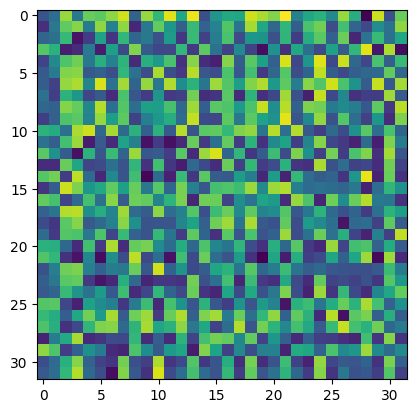

In [80]:
plt.imshow(np.array(list(head.parameters())[0].detach()))
